In [2]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import time
import os
from tqdm.notebook import tqdm
import nltk
from nltk.tokenize import sent_tokenize
import csv

In [3]:
# Download NLTK data for sentence tokenization
nltk.download('punkt', quiet=True)

True

In [4]:
# NewsAPI key
API_KEY = "f780be8fb66e4128a6b0eb41c7425f92"
BASE_URL = "https://newsapi.org/v2/everything"

In [5]:
def get_company_news(company_name, days_back=7, max_articles=10):
    """
    Fetch news articles for a specific company from the NewsAPI
    
    Args:
        company_name (str): Name of the company
        days_back (int): How many days back to search for articles (default reduced to 7)
        max_articles (int): Maximum number of articles to retrieve
        
    Returns:
        list: List of article dictionaries with title, url, source, and excerpt
    """
    # Calculate date range - limit to 7 days or less to avoid free plan limitations
    end_date = datetime.now()
    start_date = end_date - timedelta(days=min(days_back, 7))  # Ensure we don't go too far back
    
    # Format dates for API
    from_date = start_date.strftime('%Y-%m-%d')
    to_date = end_date.strftime('%Y-%m-%d')
    
    print(f"Searching for articles from {from_date} to {to_date}")
    
    # Prepare parameters
    params = {
        'q': company_name,
        'from': from_date,
        'to': to_date,
        'language': 'en',
        'sortBy': 'relevancy',
        'pageSize': max_articles,
        'apiKey': API_KEY
    }
    
    try:
        response = requests.get(BASE_URL, params=params)
        response.raise_for_status()  # Raise exception for HTTP errors
        
        data = response.json()
        
        if data['status'] != 'ok':
            print(f"Error fetching news for {company_name}: {data.get('message', 'Unknown error')}")
            return []
        
        articles = []
        for article in data.get('articles', []):
            # Extract key information
            title = article.get('title', '')
            url = article.get('url', '')
            source = article.get('source', {}).get('name', 'Unknown')
            content = article.get('content', article.get('description', ''))
            
            # Extract key excerpts using sentence tokenization
            if content:
                # Get first 2-3 sentences as excerpt
                sentences = sent_tokenize(content)
                excerpt = ' '.join(sentences[:min(3, len(sentences))])
                if len(excerpt) > 500:  # Limit excerpt length
                    excerpt = excerpt[:497] + '...'
            else:
                excerpt = "No content available"
            
            articles.append({
                'title': title,
                'url': url,
                'source': source,
                'excerpt': excerpt
            })
        
        return articles
    
    except requests.exceptions.RequestException as e:
        print(f"Request error for {company_name}: {e}")
        return []
    except Exception as e:
        print(f"Error processing news for {company_name}: {e}")
        return []

In [6]:
# Top 100 Fortune 500 companies (2023 list) - Public companies only
top_100_fortune_500 = [
    "Walmart", "Amazon", "Apple", "CVS Health", "UnitedHealth Group",
    "Exxon Mobil", "Berkshire Hathaway", "Alphabet", "McKesson", "Chevron",
    "AmerisourceBergen", "Costco Wholesale", "Microsoft", "Cardinal Health", "Cigna",
    "Marathon Petroleum", "Phillips 66", "Valero Energy", "Ford Motor", "Home Depot",
    "General Motors", "Elevance Health", "JPMorgan Chase", "Kroger", "Centene",
    "Verizon Communications", "Walgreens Boots Alliance", "Target", "AT&T", "Bank of America",
    "Meta Platforms", "Dell Technologies", "IBM", "TD Synnex", "Citigroup",
    "Comcast", "PepsiCo", "Lowe's", "Procter & Gamble", "Intel",
    "Johnson & Johnson", "Wells Fargo", "Pfizer", "Albertsons", "Walt Disney",
    "Sysco", "Humana", "FedEx", "Raytheon Technologies", "HP",
    "Boeing", "Archer Daniels Midland", "Caterpillar", "Lockheed Martin", "Morgan Stanley",
    "Dow", "Tesla", "General Electric", "HCA Healthcare", "Goldman Sachs Group",
    "Energy Transfer", "Tyson Foods", "Cisco Systems", "Charter Communications", "AbbVie",
    "Progressive", "Allstate", "Best Buy", "Merck", "TJX",
    "ConocoPhillips", "Nike", "Enterprise Products Partners", "General Dynamics", "American Express",
    "Prudential Financial", "Coca-Cola", "Bristol-Myers Squibb", "Deere", "Thermo Fisher Scientific",
    "Honeywell International", "Kraft Heinz", "Starbucks", "Qualcomm", "Abbott Laboratories",
    "Micron Technology", "Jabil", "Broadcom", "Nucor", "Danaher",
    "United Parcel Service", "Paramount Global", "US Bancorp", "Mondelez International", "Philip Morris International",
    "Lennar", "Occidental Petroleum", "Southern Company", "NextEra Energy", "Plains GP Holdings",
    "Dollar General", "Delta Air Lines", "American Airlines Group", "Marathon Oil", "Halliburton",
    "Northrop Grumman", "Travelers", "3M", "Molina Healthcare", "D.R. Horton"
]

In [7]:
# Create a directory for results if it doesn't exist
results_dir = "news_results"
os.makedirs(results_dir, exist_ok=True)

In [8]:
# Prepare CSV file for results
csv_file = os.path.join(results_dir, f"fortune500_news_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv")
print(f"Results will be saved to: {csv_file}")

Results will be saved to: news_results/fortune500_news_20250303_122104.csv


In [9]:
# Test with a single company first
test_company = "Apple"
print(f"Testing with {test_company}...")
test_articles = get_company_news(test_company, max_articles=3)

if test_articles:
    print(f"Found {len(test_articles)} articles for {test_company}")
    for i, article in enumerate(test_articles):
        print(f"\nArticle {i+1}:")
        print(f"Title: {article['title']}")
        print(f"Source: {article['source']}")
        print(f"URL: {article['url']}")
        print(f"Excerpt: {article['excerpt'][:100]}...")
else:
    print(f"No articles found for {test_company}")

Testing with Apple...
Searching for articles from 2025-02-24 to 2025-03-03
Request error for Apple: 429 Client Error:  for url: https://newsapi.org/v2/everything?q=Apple&from=2025-02-24&to=2025-03-03&language=en&sortBy=relevancy&pageSize=3&apiKey=f780be8fb66e4128a6b0eb41c7425f92
No articles found for Apple


In [15]:
# Create a list to store all article data
all_articles_data = []

# Process each company
for company in tqdm(top_100_fortune_500, desc="Processing companies"):
    print(f"\nFetching news for {company}...")
    articles = get_company_news(company)
    
    if not articles:
        print(f"No articles found for {company}")
        # Add a row indicating no articles found
        all_articles_data.append({
            'Company': company,
            'Article Title': "No articles found",
            'Source': "",
            'URL': "",
            'Excerpt': ""
        })
        continue
    
    print(f"Found {len(articles)} articles for {company}")
    
    # Add articles to the list
    for article in articles:
        all_articles_data.append({
            'Company': company,
            'Article Title': article['title'],
            'Source': article['source'],
            'URL': article['url'],
            'Excerpt': article['excerpt']
        })
    
    # Sleep to avoid hitting rate limits
    time.sleep(1)

Processing companies:   0%|          | 0/100 [00:00<?, ?it/s]


Fetching news for Walmart...
Searching for articles from 2025-02-24 to 2025-03-03
Found 10 articles for Walmart

Fetching news for Amazon...
Searching for articles from 2025-02-24 to 2025-03-03
Found 8 articles for Amazon

Fetching news for Apple...
Searching for articles from 2025-02-24 to 2025-03-03
Found 6 articles for Apple

Fetching news for CVS Health...
Searching for articles from 2025-02-24 to 2025-03-03
Found 10 articles for CVS Health

Fetching news for UnitedHealth Group...
Searching for articles from 2025-02-24 to 2025-03-03
Found 10 articles for UnitedHealth Group

Fetching news for Exxon Mobil...
Searching for articles from 2025-02-24 to 2025-03-03
Found 10 articles for Exxon Mobil

Fetching news for Berkshire Hathaway...
Searching for articles from 2025-02-24 to 2025-03-03
Found 10 articles for Berkshire Hathaway

Fetching news for Alphabet...
Searching for articles from 2025-02-24 to 2025-03-03
Found 9 articles for Alphabet

Fetching news for McKesson...
Searching for 

In [16]:
# Create DataFrame from the collected data
df = pd.DataFrame(all_articles_data)

# Display the first few rows
df.head()

,Company,Article Title,Source,URL,Excerpt
0,Walmart,The Xbox Wireless Controller is just $39 right...,The Verge,https://www.theverge.com/good-deals/620170/mic...,"Tons of colors are on sale, some cheaper than ..."
1,Walmart,Hoto’s 48-in-1 electric screwdriver set hits a...,The Verge,https://www.theverge.com/good-deals/620281/hot...,Samsungs internal gaming SSDs are also lower t...
2,Walmart,You can get four Apple AirTags for a record lo...,The Verge,https://www.theverge.com/good-deals/618895/app...,"Plus, the Galaxy Tab S9 FE is down to a record..."
3,Walmart,"Heads up, runners! The Garmin Forerunner 945 j...",Android Central,https://www.androidcentral.com/wearables/heads...,"Garmin smartwatch deals are hardly uncommon, b..."
4,Walmart,Our Favorite Internal SSD Is on Sale Right Now,Wired,https://www.wired.com/story/wd-black-sn770-dea...,Looking to upgrade the storage in your desktop...


In [19]:
# Save to CSV
df.to_csv(csv_file, index=False)
print(f"Results saved to {csv_file}")

# Save as Excel file for better formatting
excel_file = os.path.join(results_dir, f"fortune500_news_{datetime.now().strftime('%Y%m%d_%H%M%S')}.xlsx")
df.to_excel(excel_file, index=False)
print(f"Excel file saved to {excel_file}")

Results saved to news_results/fortune500_news_20250303_111329.csv
Excel file saved to news_results/fortune500_news_20250303_111728.xlsx


In [20]:
# Display summary statistics
print("Data summary:")
print(f"Total companies processed: {len(top_100_fortune_500)}")
print(f"Total articles collected: {len(df)}")
print(f"Companies with articles: {df['Company'].nunique()}")

Data summary:
Total companies processed: 100
Total articles collected: 884
Companies with articles: 99


In [21]:
# Count articles per company
articles_per_company = df['Company'].value_counts()
print("Top 10 companies by number of articles:")
articles_per_company.head(10)

Top 10 companies by number of articles:


Company
Chevron                         18
Walmart                         10
FedEx                           10
Humana                          10
Sysco                           10
ConocoPhillips                  10
Nike                            10
Pfizer                          10
Enterprise Products Partners    10
HP                              10
Name: count, dtype: int64

In [22]:
# Count articles per source
articles_per_source = df['Source'].value_counts()
print("Top 10 news sources:")
articles_per_source.head(10)

Top 10 news sources:


Source
ETF Daily News         100
Business Insider        60
Forbes                  50
Yahoo Entertainment     50
Biztoc.com              45
The Verge               43
GlobeNewswire           42
Gizmodo.com             24
Slickdeals.net          21
BBC News                19
Name: count, dtype: int64

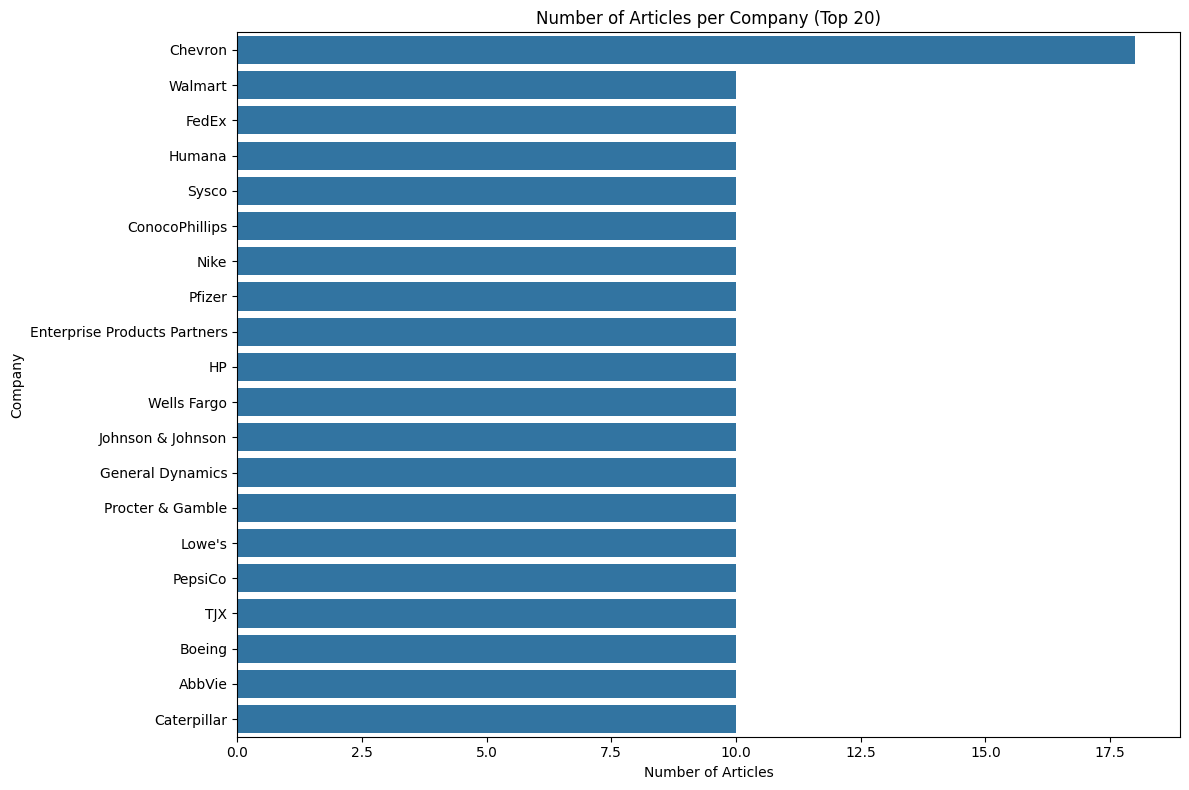

In [23]:
# Visualize articles per company (top 20)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(x=articles_per_company.head(20).values, y=articles_per_company.head(20).index)
plt.title('Number of Articles per Company (Top 20)')
plt.xlabel('Number of Articles')
plt.ylabel('Company')
plt.tight_layout()
plt.show()

In [24]:
# Convert to Parquet and store in news_results directory
import pyarrow as pa
import pyarrow.parquet as pq

# Create parquet file path
parquet_file = os.path.join(results_dir, f"fortune500_news_{datetime.now().strftime('%Y%m%d_%H%M%S')}.parquet")

# Convert DataFrame to Parquet
df.to_parquet(parquet_file, engine='pyarrow', compression='snappy')

print(f"Parquet file saved to {parquet_file}")

# Optional: Check file size comparison
csv_size = os.path.getsize(csv_file) / (1024 * 1024)  # Size in MB
parquet_size = os.path.getsize(parquet_file) / (1024 * 1024)  # Size in MB

print(f"\nFile size comparison:")
print(f"CSV file: {csv_size:.2f} MB")
print(f"Parquet file: {parquet_size:.2f} MB")
print(f"Compression ratio: {csv_size/parquet_size:.2f}x")

Parquet file saved to news_results/fortune500_news_20250303_115909.parquet

File size comparison:
CSV file: 0.35 MB
Parquet file: 0.19 MB
Compression ratio: 1.80x
